In [1]:
# import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.cluster import DBSCAN
import string
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import spacy

In [2]:
# loading the dataset
train=pd.read_csv("quora.csv")

In [3]:
train.head()

,question,Unnamed: 1
0,What is the step by step guide to invest in sh...,NaN
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,NaN
2,How can I increase the speed of my internet co...,NaN
3,Why am I mentally very lonely? How can I solve...,NaN
4,"Which one dissolve in water quikly sugar, salt...",NaN


In [4]:
train["question"].head()

0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
Name: question, dtype: object

In [5]:
#convert each question to a list of string
data = pd.Series(train["question"].tolist()).astype(str)

In [6]:
data = data[:1000]

## Text Preprocessing

In [7]:
nlp = spacy.load('en_core_web_sm')
stop_list = ['best','different',"won\'t", "couldn\'t", "mustn\'t", "didn\'t", "dtype object"]
for word in stop_list:
    spacy.lang.en.stop_words.STOP_WORDS.add(word)
    nlp.vocab[word].is_stop = True

In [8]:
def normalize(data):
    """Run all the functions for preprocessing in a pipeline"""
    clean_data = re.sub(re.compile('<.*?>'), '', data)
    cleaned_list = [ unicodedata.normalize('NFKD', word.text).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in  nlp(clean_data)]
    cleaned_list = " ".join(cleaned_list)
    cleaned_list = [word.text.rstrip('0123456789').lower() for word in nlp(cleaned_list) if word.pos_  in ['NOUN','PROPN', 'VERB'] and not word.is_digit and not word.is_punct and not word.is_stop ]
    return cleaned_list

In [9]:
# Preprocess the text data
normalized_data = []
for i, batch in data.groupby(np.arange(len(data)) // 10):
    for batch_data in batch:
        normalized_data.append(normalize(batch_data))

In [10]:
# Data after prerocessing
normalized_data 

[['step', 'step', 'guide', 'invest', 'share', 'market', 'india'],
 ['story', 'kohinoor', 'koh', 'noor', 'diamond'],
 ['increase', 'speed', 'internet', 'connection', 'vpn'],
 ['solve'],
 ['dissolve', 'water', 'sugar', 'salt', 'methane', 'carbon', 'oxide'],
 ['astrology', 'capricorn', 'sun', 'cap', 'moon', 'cap', 'rising'],
 ['buy', 'tiago'],
 ['geologist'],
 ['use'],
 ['motorola', 'company', 'hack', 'charter', 'motorolla', 'dcx'],
 ['method', 'find', 'separation', 'slits', 'fresnel', 'biprism'],
 ['read', 'find', 'youtube', 'comments'],
 ['physics', 'learn'],
 ['experience'],
 ['laws',
  'change',
  'status',
  'student',
  'visa',
  'card',
  'compare',
  'immigration',
  'laws',
  'canada'],
 ['trump', 'presidency', 'mean', 'master', 'students', 'f', 'visa'],
 ['manipulation', 'mean'],
 ['girls', 'want', 'friends', 'guy', 'reject'],
 ['quora', 'users', 'posting', 'questions', 'answered', 'google'],
 ['marketing', 'institution', 'banglore'],
 ['rockets', 'look'],
 ['causing'],
 ['quest

##  DBSCAN with Word2vec

In [11]:
def word2vec(normalized_data, size_of_features):
    """Form word2vec vectorizer for corpus """
    # train model
    model = Word2Vec(sentences = normalized_data, size = size_of_features ,workers = 4, min_count = 1)
    # summarize the loaded model
    print("Print Model ",model)
    # summarize vocabulary
    words = list(model.wv.vocab)
    print("Vocabulary: ",words)
    # access vector for one word
    print(model['step'])
    # save model
    model.save('model.bin')
    # load model
    new_model = Word2Vec.load('model.bin')
    print("New Moodel",new_model)
    new_words = list(new_model.wv.vocab)
    print("New Model words",new_words)
    return new_model

In [12]:
def average_word_vectors(words, model, vocabulary, num_features):
    """Function to calculate average of word vectors"""
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)   
    return feature_vector


In [13]:
def averaged_word_vectorizer(corpus, model, num_features):
    """ Function to calculate average word vectorizer"""
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [14]:
w2v_feature_array = averaged_word_vectorizer(corpus=normalized_data, model= word2vec(normalized_data,100), num_features=100)
pd.DataFrame(w2v_feature_array)
print(w2v_feature_array)

Print Model  Word2Vec(vocab=2254, size=100, alpha=0.025)
Vocabulary:  ['step', 'guide', 'invest', 'share', 'market', 'india', 'story', 'kohinoor', 'koh', 'noor', 'diamond', 'increase', 'speed', 'internet', 'connection', 'vpn', 'solve', 'dissolve', 'water', 'sugar', 'salt', 'methane', 'carbon', 'oxide', 'astrology', 'capricorn', 'sun', 'cap', 'moon', 'rising', 'buy', 'tiago', 'geologist', 'use', 'motorola', 'company', 'hack', 'charter', 'motorolla', 'dcx', 'method', 'find', 'separation', 'slits', 'fresnel', 'biprism', 'read', 'youtube', 'comments', 'physics', 'learn', 'experience', 'laws', 'change', 'status', 'student', 'visa', 'card', 'compare', 'immigration', 'canada', 'trump', 'presidency', 'mean', 'master', 'students', 'f', 'manipulation', 'girls', 'want', 'friends', 'guy', 'reject', 'quora', 'users', 'posting', 'questions', 'answered', 'google', 'marketing', 'institution', 'banglore', 'rockets', 'look', 'causing', 'ask', 'kv', 'hp', 'time', 'clock', 'numbers', 'tips', 'making', 'jo

/home/gargi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()
/home/gargi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [35]:
def dbscan(w2v_feature_array):
    """Function to form dbscan clusters and display them"""
#     eps = 0.005 # how close points should be to each other to be considered a part of a cluster 
#     min_samples = 3 # the minimum number of points to form a dense region  
#     dbscan = DBSCAN( eps=eps, min_samples=min_samples, metric = "cosine" ) 
#     dbscan_model = dbscan.fit(w2v_feature_array)
    
    pca = PCA(n_components=2)
    result = pca.fit_transform(w2v_feature_array)
    print(result.shape)
    db = DBSCAN(eps=0.0001, min_samples=3)
    dbscan_model = db.fit(result)
    # Forming the clusters

    core_samples_mask = np.zeros_like(dbscan_model.labels_, dtype=bool)
    core_samples_mask[dbscan_model.core_sample_indices_] = True
    labels1 = dbscan_model.labels_
    n_clusters_ = len(set(labels1)) - (1 if -1 in labels1 else 0) # Number of clusters in labels
    print(labels1)
    print(len(labels1))
    print(n_clusters_) # number of clusters
    
    clusters1 = {} # a dictionary for different cluster 
    for c, i in enumerate(labels1):
        if i == -1:
            continue
        elif i in clusters1:
            clusters1[i].append( data[c] )
        else:
            clusters1[i] = [ data[c]]

    for c in clusters1: # print the different clusters
        print("Cluster No."+" "+str(c)+" "+str(clusters1[c]))
        print()

In [37]:
dbscan(w2v_feature_array)

(1000, 2)
[ 0 -1 -1 -1 -1 -1 -1  1 -1 -1 49 -1 -1 -1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  3  4 -1 -1 -1 -1 -1  5 -1 -1 30 -1 -1 -1  6  7 20 -1 -1 50
 -1 -1 -1 -1  8 -1 -1 -1 -1 47 -1  9 -1 -1 -1  8 -1 19 -1 -1 -1  6 -1 26
 -1 -1 -1 -1 42 10 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 11 -1 -1 12 38 -1 -1 -1 -1 -1 -1 13 14 15 -1  6 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  7 -1 -1 16 -1 -1 -1 -1 -1 17 -1 -1 -1 -1 -1 -1 -1 18 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  8 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 32 -1 -1 -1 -1 19 -1 28 -1 -1 -1 -1 -1 20 -1 -1 -1 -1 -1 -1 -1 17 -1 -1
 -1 -1 17 -1 -1  1 -1 36 18 -1 -1 -1 -1 17 -1 -1 -1 21 -1 22 17 -1 -1 -1
 -1 23 -1 -1 -1 -1 -1 -1 12 24 -1 -1 -1 -1 -1 -1 13 16 -1 -1 -1  7 -1 -1
 39 -1 -1 43 46 -1 25 -1  6 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 26 10 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1  3 -1 -1 -1 -1 -1  7 -1 -1 27 -1 22 -1 -1 -1 -1
 -1 17 11 -1  8 -1 -1 28 -1 -1 10 -1 -1 42 -1 -1 -1 -1 -1 -1 -1 -1 48 -1
 -1 -1 -1 15 -1 -1 -1 -1 -1 -1 29  4 -1 -

(1000, 2)


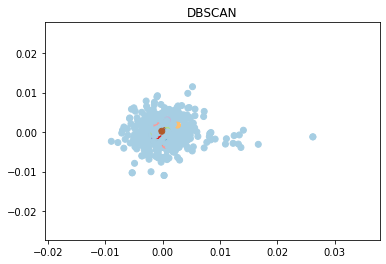

In [26]:
from sklearn.decomposition import PCA

def plot_dbscan(X , eps=0.0001, min_samples=3):
    """Function to plot clusters"""
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    print(result.shape)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(result)
    y_pred = db.fit_predict(result)
    plt.scatter(result[:,0], result[:,1],c=y_pred, cmap='Paired')
    plt.title("DBSCAN")
    
plot_dbscan( w2v_feature_array,0.0001, 3)